## Environnement Frozen Lake

Dans ce notebook on considère l'environnement Frozen Lake de la bibliothèque `Gym`, illustré ci-dessous :

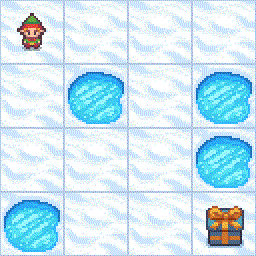

Il s'agit d'un environnement de type "grid world" de taille 4x4, avec une position de départ, une position à atteindre. Un épisode se termine lorsque l'agent atteint l'objectif ou tombe dans un trou.
Il ne reçoit de récompense que lorsqu'il atteint l'objectif.
On note également qu'un lac gelé, ça glisse ! L'agent ne réussit pas toujours à aller là où il le souhaite.
L'agent ne dispose que de 4 actions : gauche, bas, droite, haut.

## L'algorithme de Q-learning

Le principe de cet algorithme consiste à estimer la valeur de chaque paire (état, action), c'est-à-dire estimer $Q(s,a)$ à partir des interactions de l'agent avec l'environnement. Si l'estimation est bonne, la politique de l'agent pourra consister simplement à sélectionner dans l'état $s$ l'action $a$ dont la valeur $Q(s,a)$ est maximale dans l'état $s$

L'algorithme consiste à itérer sur les 3 étapes suivantes jusqu'à convergence :

1. Choisir une action $a$ et l'exécuter
2. Observer $r$ et $s'$.
3. Mettre à jour $Q(s,a) \leftarrow Q(s,a) + \alpha [r + \gamma {\max_{a' \in A} Q(s',a')}- Q(s,a) ]$.

Dans l'environnement que l'on considère ici, il n'y a que 4 actions possibles, et 16 cases (dont certaines terminales). Il est possible de stocker les valeurs de la fonction $Q(s,a)$ dans un tableau. On parle ainsi de Q-learning tabulaire.

## Implémentation de l'algorithme de Q-learning tabulaire

### Imports python :

In [1]:
#!/usr/bin/env python3
import gym
import numpy as np

# Pour utiliser les outils de visualisation des logs de tensorboard:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

### Configuration des hyper-paramètres

In [2]:
GAMMA = 0.9
ALPHA = 0.2
TEST_EPISODES = 20

## Définition de l'agent:

On définit une classe agent, qui sera caractérisée par son état et sa table des valeurs $Q(s,a)$

In [30]:
class Agent:
    def __init__(self):
        self.env = gym.make("FrozenLake-v1" ,is_slippery=True)
        self.state = self.env.reset()
        self.q_values = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        
    # Get the new transition by interacting with the environment
    def sample_env(self):
        action = self.env.action_space.sample()
        old_state = self.state
        new_state, reward, is_done,_ = self.env.step(action)
        self.state = self.env.reset() if is_done else new_state
        return old_state, action, reward, new_state

    # Finds the best action to take from state s given the Q-table
    # returns corresponding q-value and best action
    def best_value_and_action(self, state):
        best_qvalue, best_action = None, None
        for action in range(self.env.action_space.n):
            action_value = self.q_values[state, action]
            if best_qvalue is None or best_qvalue < action_value:
                best_qvalue = action_value
                best_action = action
        return best_qvalue, best_action

    # Update the Q-value using the transition
    def q_value_update(self, s, a, r, next_s):
        best_q, _ = self.best_value_and_action(next_s)
        new_q = r + GAMMA * best_q
        old_q = self.q_values[s, a]
        self.q_values[s, a] = old_q * (1-ALPHA) + new_q * ALPHA

    # Plays a full episod 
    # (no update here, just to evaluate the current policy to monitor progress)
    def play_episode(self, env):
        total_reward = 0.0
        state = env.reset()
        while True:
            _, action = self.best_value_and_action(state)
            new_state, reward, is_done,_ = env.step(action)
            total_reward += reward
            if is_done:
                break
            state = new_state
        return total_reward  

Train the agent :

In [31]:
agent = Agent()
writer = SummaryWriter('runs/q_learning_tabular_Frozen1')
print("Dimensions de l'espace d'état et d'action : ", agent.env.observation_space.n, agent.env.action_space.n)
test_env=env = gym.make("FrozenLake-v1" ,is_slippery=True)

iter_no = 0
best_reward = 0.0
while True:
    iter_no += 1
    print('------------iter number : ' , iter_no)
    #Interaction avec l'environnement
    s, a, r, next_s = agent.sample_env() 
    #Rendering
    agent.env.render()
    print('')
    #Mise à jour de la Qvalue
    agent.q_value_update(s, a, r, next_s) 
    
    #Calcul récompense cumulée moyenne sur un ensemble d'épisodes de test pour évaluer la politique
    reward = 0.0
    for _ in range(TEST_EPISODES):
        reward += agent.play_episode(test_env)                
    reward /= TEST_EPISODES  #récompense cumulée moyenne sur les episodes de test
    writer.add_scalar("reward", reward, iter_no)
    if reward > best_reward:
        print("Best reward updated %.3f -> %.3f" % (
            best_reward, reward))
        best_reward = reward
    if reward > 0.80:
        print("Solved in %d iterations!" % iter_no)
        break
writer.close()

Dimensions de l'espace d'état et d'action :  16 4
------------iter number :  1
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2

SFFF
FHFH
FFFH
HFFG

------------iter number :  3
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  7
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  8
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  9
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  10
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  11
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  12
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  13

SFFF
FHFH
FFFH
HFFG

------------iter number :  14
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  15
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  16
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter numb

------------iter number :  175
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  176
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  177
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  178
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  179

SFFF
FHFH
FFFH
HFFG

------------iter number :  180
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  181

SFFF
FHFH
FFFH
HFFG

------------iter number :  182
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  183
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  184
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  185
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  186
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  187

SFFF
FHFH
FFFH
HFFG

------------iter number :  188
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  189
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  190
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  191
  (Down)
SFF

------------iter number :  321
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  322
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  323
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  324
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  325
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  326
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  327
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  328

SFFF
FHFH
FFFH
HFFG

------------iter number :  329
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  330
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  331
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  332

SFFF
FHFH
FFFH
HFFG

------------iter number :  333
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  334
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  335
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  336
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  337

SFFF
FHFH
F

------------iter number :  471
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  472
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  473
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  474

SFFF
FHFH
FFFH
HFFG

------------iter number :  475
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  476
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  477
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  478

SFFF
FHFH
FFFH
HFFG

------------iter number :  479
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  480
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  481
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  482
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  483
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  484
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  485

SFFF
FHFH
FFFH
HFFG

------------iter number :  486
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  487
  (Right)
SFFF
FHFH
F

------------iter number :  593
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  594
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  595

SFFF
FHFH
FFFH
HFFG

------------iter number :  596
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  597
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  598
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  599
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  600
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  601
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  602
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  603
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  604

SFFF
FHFH
FFFH
HFFG

------------iter number :  605
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  606
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  607
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  608
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  609
  (Up)
SFFF
FHFH
FF

------------iter number :  756

SFFF
FHFH
FFFH
HFFG

------------iter number :  757
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  758

SFFF
FHFH
FFFH
HFFG

------------iter number :  759
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  760
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  761
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  762
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  763
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  764
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  765

SFFF
FHFH
FFFH
HFFG

------------iter number :  766
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  767
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  768
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  769
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  770
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  771
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  772
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  891
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  892
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  893
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  894
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  895
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  896
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  897
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  898
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  899

SFFF
FHFH
FFFH
HFFG

------------iter number :  900
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  901
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  902
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  903
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  904
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  905
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  906
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  907


------------iter number :  1102
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1103
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1104

SFFF
FHFH
FFFH
HFFG

------------iter number :  1105
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1106
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1107
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1108
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1109
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1110
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1111
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1112
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1113
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1114
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1115

SFFF
FHFH
FFFH
HFFG

------------iter number :  1116
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1117
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :

------------iter number :  1315
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1316
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1317

SFFF
FHFH
FFFH
HFFG

------------iter number :  1318
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1319

SFFF
FHFH
FFFH
HFFG

------------iter number :  1320
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1321
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1322
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1323
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1324
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1325
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1326
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1327
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1328
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1329
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1330

SFFF
FHFH
FFFH
HFFG

------------iter number :  1331
  (Right)

------------iter number :  1443
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1444
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1445
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1446

SFFF
FHFH
FFFH
HFFG

------------iter number :  1447
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1448
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1449
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1450

SFFF
FHFH
FFFH
HFFG

------------iter number :  1451
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1452
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1453

SFFF
FHFH
FFFH
HFFG

------------iter number :  1454
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1455
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1456
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1457
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1458
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1459
 

------------iter number :  1619
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1620
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1621
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1622
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1623
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1624
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1625
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1626
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1627
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1628
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1629

SFFF
FHFH
FFFH
HFFG

------------iter number :  1630
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1631
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1632
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1633
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1634
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter

------------iter number :  1765
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1766
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1767
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1768
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1769
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1770
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1771
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1772
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1773

SFFF
FHFH
FFFH
HFFG

------------iter number :  1774
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1775

SFFF
FHFH
FFFH
HFFG

------------iter number :  1776
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1777
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1778

SFFF
FHFH
FFFH
HFFG

------------iter number :  1779
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1780

SFFF
FHFH
FFFH
HFFG

------------iter number :  1781
  (Righ

------------iter number :  1927

SFFF
FHFH
FFFH
HFFG

------------iter number :  1928
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1929

SFFF
FHFH
FFFH
HFFG

------------iter number :  1930
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1931
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1932
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1933
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1934
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1935
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1936
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1937

SFFF
FHFH
FFFH
HFFG

------------iter number :  1938
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1939
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1940
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1941

SFFF
FHFH
FFFH
HFFG

------------iter number :  1942
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  1943
  (Right)

------------iter number :  2134
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2135
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2136
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2137
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2138

SFFF
FHFH
FFFH
HFFG

------------iter number :  2139
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2140
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2141
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2142
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2143
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2144

SFFF
FHFH
FFFH
HFFG

------------iter number :  2145
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2146
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2147
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2148
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2149
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  215

------------iter number :  2300
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2301
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2302
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2303
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2304
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2305

SFFF
FHFH
FFFH
HFFG

------------iter number :  2306
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2307
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2308
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2309
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2310
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2311
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2312
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2313
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2314
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2315
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter numbe

------------iter number :  2501
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2502
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2503
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2504
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2505
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2506
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2507
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2508

SFFF
FHFH
FFFH
HFFG

------------iter number :  2509
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2510
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2511
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2512
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2513
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2514
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2515
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2516
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number

------------iter number :  2683
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2684
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2685
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2686
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2687
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2688
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2689
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2690
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2691
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2692

SFFF
FHFH
FFFH
HFFG

------------iter number :  2693
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2694
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2695
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2696
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2697

SFFF
FHFH
FFFH
HFFG

------------iter number :  2698
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2

------------iter number :  2818
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2819
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2820
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2821
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2822
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2823
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2824
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2825
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2826

SFFF
FHFH
FFFH
HFFG

------------iter number :  2827
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2828
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2829

SFFF
FHFH
FFFH
HFFG

------------iter number :  2830
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2831
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2832
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  2833
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  283

------------iter number :  3028

SFFF
FHFH
FFFH
HFFG

------------iter number :  3029
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3030
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3031

SFFF
FHFH
FFFH
HFFG

------------iter number :  3032
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3033
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3034
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3035
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3036
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3037
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3038
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3039
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3040
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3041
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3042
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3043
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  

------------iter number :  3160
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3161
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3162
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3163
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3164
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3165
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3166

SFFF
FHFH
FFFH
HFFG

------------iter number :  3167
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3168
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3169

SFFF
FHFH
FFFH
HFFG

------------iter number :  3170
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3171
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3172
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3173
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3174
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3175
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3176

------------iter number :  3301
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3302
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3303
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3304
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3305
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3306
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3307
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3308
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3309
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3310
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3311
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3312
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3313
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3314
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3315
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3316
  (Left)
SFFF
FHFH
FFFH
HFFG

------

------------iter number :  3447
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3448
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3449
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3450
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3451
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3452

SFFF
FHFH
FFFH
HFFG

------------iter number :  3453
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3454

SFFF
FHFH
FFFH
HFFG

------------iter number :  3455
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3456

SFFF
FHFH
FFFH
HFFG

------------iter number :  3457
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3458
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3459
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3460

SFFF
FHFH
FFFH
HFFG

------------iter number :  3461
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3462
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3463
  (Down)
SFFF

------------iter number :  3601
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3602

SFFF
FHFH
FFFH
HFFG

------------iter number :  3603
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3604
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3605
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3606
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3607

SFFF
FHFH
FFFH
HFFG

------------iter number :  3608
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3609
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3610

SFFF
FHFH
FFFH
HFFG

------------iter number :  3611
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3612
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3613
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3614
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3615
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3616
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3617
  (Right)
SFF

------------iter number :  3737
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3738
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3739
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3740
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3741

SFFF
FHFH
FFFH
HFFG

------------iter number :  3742
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3743
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3744
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3745
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3746
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3747
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3748
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3749
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3750
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3751
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3752

SFFF
FHFH
FFFH
HFFG

------------iter number :  375

------------iter number :  3941
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3942
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3943
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3944
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3945
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3946

SFFF
FHFH
FFFH
HFFG

------------iter number :  3947
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3948
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3949
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3950
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3951
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3952
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3953
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3954
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3955
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  3956
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter

------------iter number :  4067
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4068
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4069
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4070
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4071
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4072
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4073
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4074
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4075
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4076
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4077
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4078
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4079
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4080
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4081
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4082
  (Down)
SFFF
FHFH
FFFH
HFFG

-------

------------iter number :  4192
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4193
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4194
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4195
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4196
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4197
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4198
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4199
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4200
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4201
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4202
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4203
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4204
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4205
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4206
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4207
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter n

------------iter number :  4333
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4334
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4335
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4336
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4337

SFFF
FHFH
FFFH
HFFG

------------iter number :  4338
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4339

SFFF
FHFH
FFFH
HFFG

------------iter number :  4340
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4341
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4342
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4343
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4344
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4345
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4346
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4347
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4348
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  43

------------iter number :  4533

SFFF
FHFH
FFFH
HFFG

------------iter number :  4534
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4535
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4536
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4537
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4538
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4539

SFFF
FHFH
FFFH
HFFG

------------iter number :  4540
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4541
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4542
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4543
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4544

SFFF
FHFH
FFFH
HFFG

------------iter number :  4545
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4546
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4547

SFFF
FHFH
FFFH
HFFG

------------iter number :  4548
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4549
  (Up)
SFFF
FHF

------------iter number :  4664
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4665
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4666

SFFF
FHFH
FFFH
HFFG

------------iter number :  4667
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4668
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4669
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4670
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4671
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4672
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4673

SFFF
FHFH
FFFH
HFFG

------------iter number :  4674
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4675
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4676
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4677
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4678
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4679
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number

------------iter number :  4790
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4791
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4792
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4793
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4794

SFFF
FHFH
FFFH
HFFG

------------iter number :  4795
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4796
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4797

SFFF
FHFH
FFFH
HFFG

------------iter number :  4798
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4799
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4800
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4801
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4802
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4803
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4804
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4805

SFFF
FHFH
FFFH
HFFG

------------iter number :  4

------------iter number :  4930
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4931
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4932
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4933
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4934

SFFF
FHFH
FFFH
HFFG

------------iter number :  4935
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4936
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4937
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4938
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4939
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4940
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4941

SFFF
FHFH
FFFH
HFFG

------------iter number :  4942
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4943
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4944
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  4945
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  

------------iter number :  5095
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5096
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5097
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5098
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5099
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5100
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5101
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5102

SFFF
FHFH
FFFH
HFFG

------------iter number :  5103
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5104
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5105
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5106

SFFF
FHFH
FFFH
HFFG

------------iter number :  5107
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5108
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5109
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5110
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5

------------iter number :  5218
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5219
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5220
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5221
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5222
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5223
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5224

SFFF
FHFH
FFFH
HFFG

------------iter number :  5225
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5226
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5227

SFFF
FHFH
FFFH
HFFG

------------iter number :  5228
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5229
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5230
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5231
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5232
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5233
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number 

------------iter number :  5373
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5374
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5375
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5376
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5377
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5378
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5379
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5380
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5381
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5382
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5383
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5384
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5385
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5386

SFFF
FHFH
FFFH
HFFG

------------iter number :  5387
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5388
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter nu

------------iter number :  5497
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5498
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5499
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5500

SFFF
FHFH
FFFH
HFFG

------------iter number :  5501
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5502
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5503
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5504
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5505
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5506
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5507
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5508
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5509

SFFF
FHFH
FFFH
HFFG

------------iter number :  5510
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5511
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5512
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5513
 

------------iter number :  5619
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5620
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5621
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5622

SFFF
FHFH
FFFH
HFFG

------------iter number :  5623
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5624
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5625
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5626
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5627

SFFF
FHFH
FFFH
HFFG

------------iter number :  5628
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5629
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5630
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5631
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5632

SFFF
FHFH
FFFH
HFFG

------------iter number :  5633
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5634
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5635

SFFF
F

------------iter number :  5752
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5753

SFFF
FHFH
FFFH
HFFG

------------iter number :  5754
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5755
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5756
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5757
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5758
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5759
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5760
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5761

SFFF
FHFH
FFFH
HFFG

------------iter number :  5762
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5763
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5764
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5765
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5766
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5767

SFFF
FHFH
FFFH
HFFG

------------iter number :  5768
  

------------iter number :  5891

SFFF
FHFH
FFFH
HFFG

------------iter number :  5892
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5893
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5894
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5895
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5896
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5897

SFFF
FHFH
FFFH
HFFG

------------iter number :  5898
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5899
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5900

SFFF
FHFH
FFFH
HFFG

------------iter number :  5901
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5902
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5903
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5904
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5905
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5906
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  5907
  

------------iter number :  6066
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6067
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6068
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6069
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6070
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6071
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6072
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6073
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6074
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6075
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6076
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6077
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6078
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6079
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6080
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6081

SFFF
FHFH
FFFH
HFFG

------------iter n

------------iter number :  6210
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6211

SFFF
FHFH
FFFH
HFFG

------------iter number :  6212
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6213

SFFF
FHFH
FFFH
HFFG

------------iter number :  6214
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6215
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6216
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6217
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6218
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6219
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6220
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6221

SFFF
FHFH
FFFH
HFFG

------------iter number :  6222
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6223
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6224
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6225
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6226
  (Down)


------------iter number :  6331
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6332

SFFF
FHFH
FFFH
HFFG

------------iter number :  6333
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6334
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6335
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6336
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6337
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6338
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6339
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6340
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6341
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6342
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6343

SFFF
FHFH
FFFH
HFFG

------------iter number :  6344
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6345
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6346
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6347
 

------------iter number :  6487
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6488
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6489
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6490
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6491
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6492
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6493

SFFF
FHFH
FFFH
HFFG

------------iter number :  6494
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6495
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6496
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6497

SFFF
FHFH
FFFH
HFFG

------------iter number :  6498
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6499
  (Up)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6500
  (Right)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6501
  (Left)
SFFF
FHFH
FFFH
HFFG

------------iter number :  6502
  (Down)
SFFF
FHFH
FFFH
HFFG

------------iter number

In [32]:
print(agent.q_values)

[[0.06512674 0.06255107 0.06302043 0.05600863]
 [0.03187227 0.0282583  0.05834135 0.05862221]
 [0.06156959 0.08605072 0.07348017 0.06016373]
 [0.04817905 0.01751924 0.02470695 0.05628786]
 [0.07824328 0.05844844 0.06151252 0.05773868]
 [0.         0.         0.         0.        ]
 [0.13809656 0.10026631 0.08548507 0.00608662]
 [0.         0.         0.         0.        ]
 [0.06581097 0.05485419 0.08704247 0.13202945]
 [0.10845117 0.19150823 0.14513275 0.12756824]
 [0.2206712  0.08763462 0.13501435 0.08656724]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.0512639  0.23417814 0.25362839 0.24488057]
 [0.30739715 0.48100987 0.46434795 0.40791718]
 [0.         0.         0.         0.        ]]


In [20]:
%tensorboard --logdir=runs